In [1]:
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import albumentations as A
import wandb
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image

In [2]:
wandb.init(project='unet', entity='dokturdro')
data_path = os.path.dirname(os.getcwd()) + "\_datasets"

PATH_IMG = data_path + "/nuclei/images/"
PATH_MASK = data_path + "/nuclei/masks/"
# TRAIN_IMG_DIR = "nuclei/train/images/"
# TRAIN_MASK_DIR = "nuclei/train/masks/"
# VAL_IMG_DIR = "nuclei/test/images/"
# VAL_MASK_DIR = "nuclei/test/masks/"
RESIZE = 128

wandb: Currently logged in as: dokturdro (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [16]:
class NucleiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        print(image_dir)
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        print(self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace("original.jpg", "mask.jpg"))
        image_ = Image.open(img_path)
        print(image_)
        image = np.array(Image.open(img_path).resize((RESIZE, RESIZE)).convert("RGB"), dtype=np.float32)
        print('image', image)
        mask = np.array(Image.open(mask_path).resize((RESIZE, RESIZE)).convert("L"), dtype=np.float32)
        mask = mask/255
        image = image.transpose(2, 0, 1)
        return image, mask

In [17]:
data = NucleiDataset(PATH_IMG, PATH_MASK)
len(data)

C:\Users\mdro\Desktop\programming\git\Data_Science\_datasets/nuclei/images/


141

In [18]:
x, y = data[len(data) - 1]
x.shape, y.shape

9382_500_f00029_original.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x19F88870EE0>
image [[[102.  71. 124.]
  [159. 129. 167.]
  [214. 186. 218.]
  ...
  [104.  73. 118.]
  [150. 114. 159.]
  [148. 111. 153.]]

 [[100.  62. 105.]
  [176. 140. 175.]
  [201. 161. 196.]
  ...
  [108.  70. 120.]
  [149. 108. 156.]
  [161. 122. 173.]]

 [[185. 156. 191.]
  [207. 180. 210.]
  [165. 126. 160.]
  ...
  [127.  80. 134.]
  [ 99.  58. 109.]
  [109.  74. 124.]]

 ...

 [[229. 206. 226.]
  [228. 216. 226.]
  [163. 123. 157.]
  ...
  [244. 233. 241.]
  [238. 227. 236.]
  [220. 193. 216.]]

 [[183. 149. 180.]
  [236. 225. 229.]
  [220. 190. 219.]
  ...
  [231. 216. 231.]
  [220. 200. 221.]
  [152. 112. 160.]]

 [[162. 117. 165.]
  [217. 190. 209.]
  [218. 193. 217.]
  ...
  [196. 175. 200.]
  [179. 149. 188.]
  [104.  64. 123.]]]


((3, 128, 128), (128, 128))

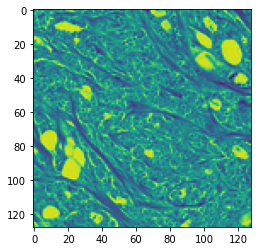

In [10]:
plt.imshow(x[2])

In [11]:
train_ds, valid_ds = torch.utils.data.random_split(data, (100, 41))

In [12]:
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=10, shuffle=True)

In [13]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

8951_500_f00082_original.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x19F88978400>
9256_500_f00216_original.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x19F889B0D90>
12911_500_f00082_original.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x19F88870700>
13402_500_f00080_original.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x19F889B0910>
12821_500_f00066_original.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x19F889B0910>
9037_500_f00012_original.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x19F889C5280>
9022_500_f00027_original.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x19F889C50A0>
13689_500_f00011_original.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x19F889C53A0>
12752_500_f00057_original.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x19F889C51F0>
13459

(torch.Size([10, 3, 128, 128]), torch.Size([10, 128, 128]))

In [ ]:
class double_conv(nn.Module):
    '''
    Double Convolution layer with both 2 BN and Activation Layer in between
    Conv2d==>BN==>Activation==>Conv2d==>BN==>Activation
    '''
    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel),
            nn.Conv2d(out_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel)
        )
    def forward(self, x):
        x = self.conv(x)
        return x

class down_conv(nn.Module):
    '''
    A maxpool layer followed by a Double Convolution.
    MaxPool2d==>double_conv.
    '''
    def __init__(self, in_channel, out_channel):
        super(down_conv, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_channel, out_channel)
        )
    def forward(self, x):
        x = self.down(x)
        return x

class up_sample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(up_sample, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = double_conv(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.double_conv(x)
        return x

class UNet(nn.Module):
    '''Main Unet Model'''
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        self.down_block1 = double_conv(in_channel, 16)
        self.down_block2 = down_conv(16, 32)
        self.down_block3 = down_conv(32, 64)
        self.down_block4 = down_conv(64, 128)
        self.down_block5 = down_conv(128, 256)
        self.down_block6 = down_conv(256, 512)
        self.down_block7 = down_conv(512, 1024)

        self.up_block1 = up_sample(1024+512, 512)
        self.up_block2 = up_sample(512+256, 256)
        self.up_block3 = up_sample(256+128, 128)
        self.up_block4 = up_sample(128+64, 64)
        self.up_block5 = up_sample(64+32, 32)
        self.up_block6 = up_sample(32+16, 16)
        self.up_block7 = nn.Conv2d(16, out_channel, 1)


    def forward(self, x):
        x1 = self.down_block1(x)
        x2 = self.down_block2(x1)
        x3 = self.down_block3(x2)
        x4 = self.down_block4(x3)
        x5 = self.down_block5(x4)
        x6 = self.down_block6(x5)
        x7 = self.down_block7(x6)

        x8 = self.up_block1(x7, x6)
        x9 = self.up_block2(x8, x5)
        x10 = self.up_block3(x9, x4)
        x11 = self.up_block4(x10, x3)
        x12 = self.up_block5(x11, x2)
        x13 = self.up_block6(x12, x1)
        x14 = self.up_block7(x13)
        out = torch.sigmoid(x14)
        return out

In [ ]:
unet = UNet(3,2)

In [ ]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

In [ ]:
pred = unet(xb)
pred.shape

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model = model.to(device)

    train_loss = []
    valid_loss = []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)
                dataloader = train_dl
            else:
                model.train(False)
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0
            
            for x, y in dataloader:
                x = x.to(device)
                y = y.type(torch.LongTensor).to(device)
                step += 1

                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)
                    
                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:

                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    wandb.log({'epoch': epoch, 'loss': running_loss})
                    
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.to(device)).float().mean()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=50)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot([loss.detach().cpu().numpy() for loss in train_loss], label='Train loss')
plt.plot([valid.detach().cpu().numpy() for valid in valid_loss], label='Valid loss')
plt.legend()